# Video pipeline with Yolo + Resnet Model

In [1]:
import pandas as pd
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser

In [2]:
serieses = [63, 64]

series_paths = {series: os.path.join(FINAL_RESULTS_PATH, "series", str(series)) for series in serieses}

loaders = {series: AdaptationParser(series_path=series_path, model_name="video", type_of="pipeline") for series, series_path in series_paths.items()}

In [3]:
loaders

{63: <experiments.utils.parser.AdaptationParser at 0x7f98d01ec6d0>,
 64: <experiments.utils.parser.AdaptationParser at 0x7f98d01ec5b0>}

In [4]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp['0.yaml']
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 63 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 20,
    'allocation_mode': 'base',
    'alpha': 0,
    'baseline_mode': 'scale',
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 10,
    'gamma': 0,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'metadata': 'repeat of 62 with increase of queues to 120s and other to 30s',
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 10,
    'nodes': [   {   'cpu_request': '2',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
                     'memory_request': '2Gi',
                     'model_variants': 'yolov5n',
                     'node_name': 'yolo',
                     'num_interop_

In [5]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [6]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{63: False, 64: True}

In [7]:
adaptation_logs = dict(map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items()))

In [8]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(adaptation_log=adaptation_logs[series])

## Comparing Predicted Load with the Recieved Load

-------------------------------------------------- 63 --------------------------------------------------
[5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25, 24, 25, 24, 23, 25, 24, 25, 23, 30, 28, 26, 25, 26, 27, 27, 27, 28, 30, 25, 26, 29, 26, 26, 29, 27, 29, 29, 28, 29, 26, 26, 24, 27, 28, 26, 29, 28, 29, 26, 26, 32, 24, 26, 26, 26, 26, 24, 25, 28, 27, 29, 26, 26, 26, 31, 30, 26, 29, 33, 29, 28, 29, 28, 30, 28, 29, 29, 26, 25, 27, 28, 27, 25]
[0.0, 4.905, 7.0, 5.0, 6.0, 5.0, 4.0, 5.0, 6.0, 6.0, 6.0, 10.0, 7.0, 5.0, 7.0, 4.0, 7.0, 4.0, 6.0, 6.0, 5.0, 8.0, 5.0, 7.0, 6.0, 5.0, 4.0, 5.0, 6.0, 5.0, 7.0, 5.0, 5.0, 6.0, 6.0, 6.0, 5.0, 6.0, 5.0, 7.0, 6.0, 8.0, 5.0, 6.0, 6.0, 5.0, 6.0, 7.0, 5.0, 6.0, 6.0, 5.0, 6.0, 7.0, 6.0, 8.0, 8.0, 5.0, 8.0, 9.0, 16.0, 25.0, 14.0, 25.0, 32.0, 16.0, 20.0, 21.0,

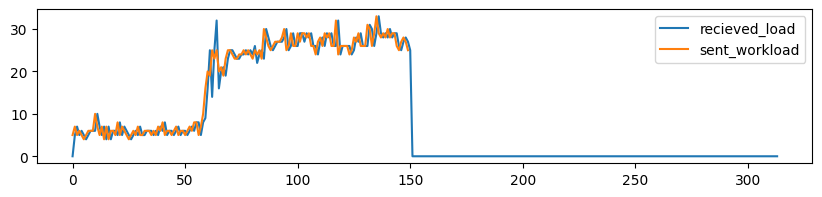

-------------------------------------------------- 64 --------------------------------------------------
[5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25, 24, 25, 24, 23, 25, 24, 25, 23, 30, 28, 26, 25, 26, 27, 27, 27, 28, 30, 25, 26, 29, 26, 26, 29, 27, 29, 29, 28, 29, 26, 26, 24, 27, 28, 26, 29, 28, 29, 26, 26, 32, 24, 26, 26, 26, 26, 24, 25, 28, 27, 29, 26, 26, 26, 31, 30, 26, 29, 33, 29, 28, 29, 28, 30, 28, 29, 29, 26, 25, 27, 28, 27, 25]
[5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25, 24, 25, 24, 23, 25, 24, 25, 23, 30, 28, 26, 25, 26, 27, 27, 27, 28, 30, 25, 26, 29, 26, 26, 29, 27,

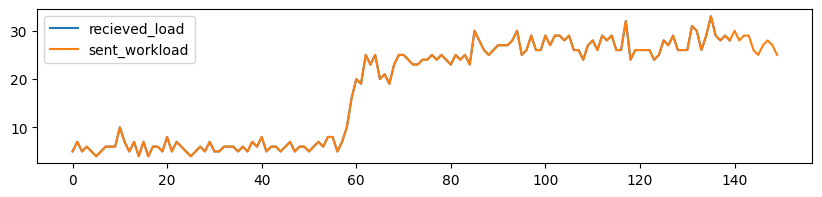

In [9]:
for series, series_values in series_changes.items():
    print(50 * "-" + f" {series} " + 50 * "-")
    recieved_load = series_changes[series]["recieved_load"]
    # recieved_load = [int(item) for item in recieved_load if item != 0]
    recieved_load_x = [x for x in range(0, len(recieved_load))]
    sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    print(sent_loads[series])
    print(recieved_load)

    print(len(sent_loads[series]))
    print(len(recieved_load))
    plt.figure(figsize=(10, 2))
    plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    plt.plot(sent_load_x, sent_loads[series], label="sent_workload")
    # TODO add predicted reference load here
    plt.legend()
    plt.show()

In [10]:
def draw_dicts(dict_to_draw: Dict[str, List[int]], adaptation_interval=None):
    num_keys = len(dict_to_draw.keys())
    fig, axs = plt.subplots(nrows=num_keys, ncols=1, figsize=(10, num_keys * 2))
    x_values = range(len(list(dict_to_draw.values())[0]))
    if adaptation_interval is not None:
        x_values = [item * adaptation_interval for item in list(x_values)]
    if num_keys > 1:
        for i, key in enumerate(dict_to_draw.keys()):
            axs[i].plot(x_values, dict_to_draw[key], label=key)
            axs[i].set_title(key)
            axs[i].legend()
    else:
        key = list(dict_to_draw.keys())[0]
        axs.plot(x_values, dict_to_draw[key], label=key)
        axs.set_title(key)
        axs.legend()

    plt.tight_layout()
    plt.show()

## Replica Changes
1. Total
2. Per node

-------------------------------------------------- 63 --------------------------------------------------


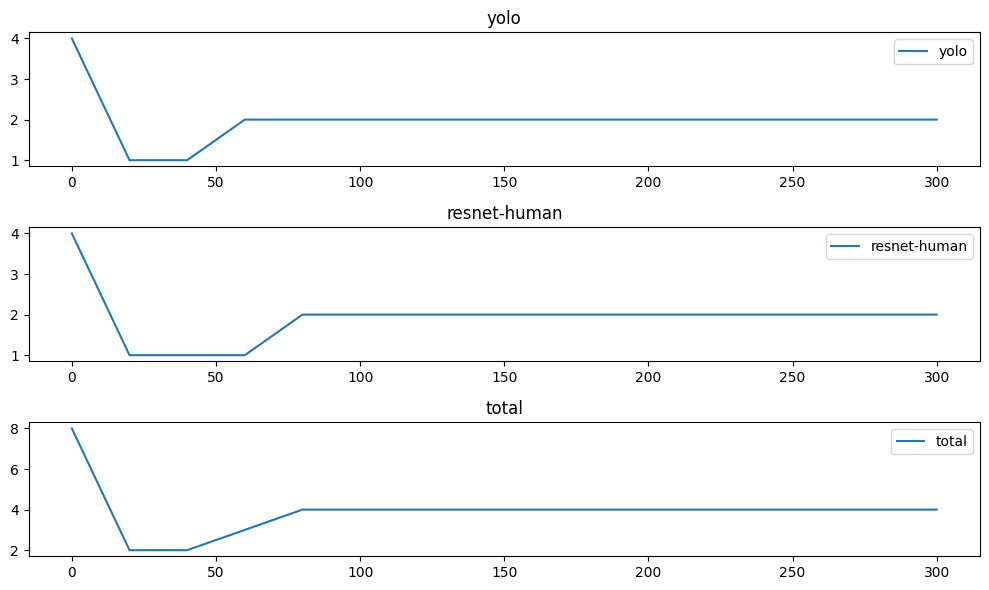

-------------------------------------------------- 64 --------------------------------------------------


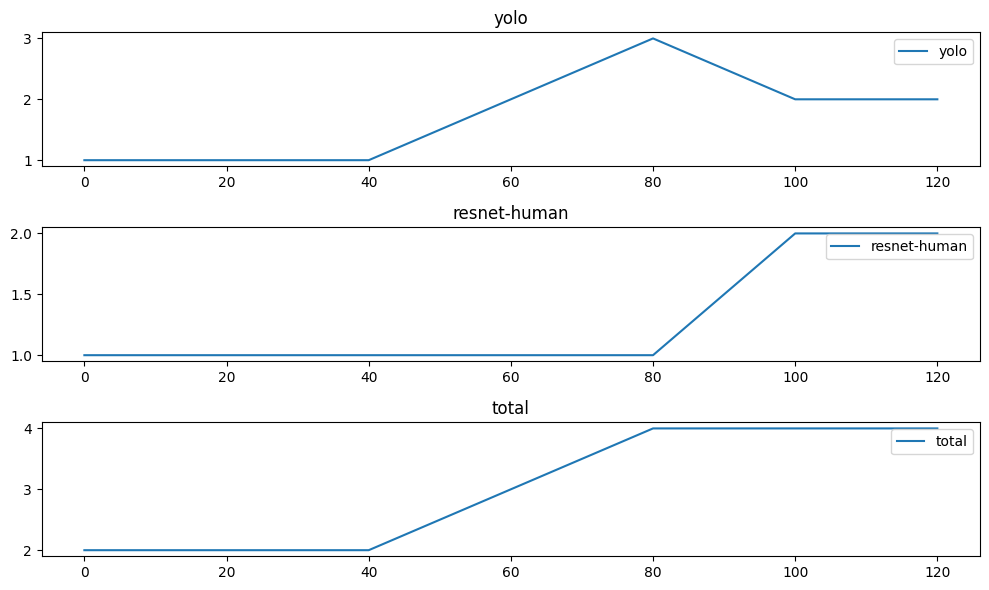

In [13]:
replica_changes = {}
for series, series_values in series_changes.items():
    print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [sum(x) for x in zip(*replica_changes[series].values())]
    draw_dicts(replica_changes[series], adaptation_intervals[series])

## Per Container Core changes
1. Total
2. Per Node

-------------------------------------------------- 63 --------------------------------------------------


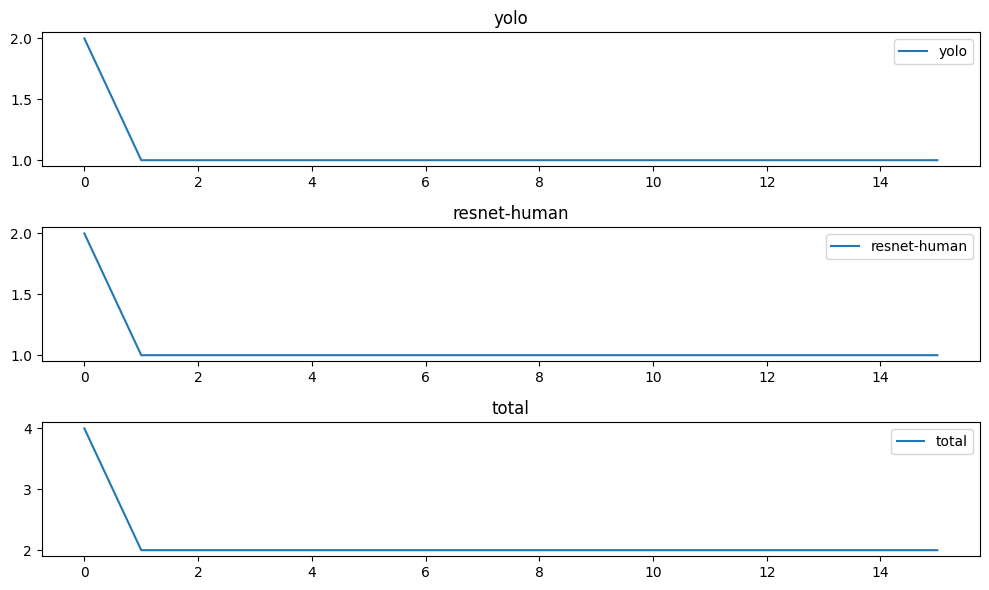

-------------------------------------------------- 64 --------------------------------------------------


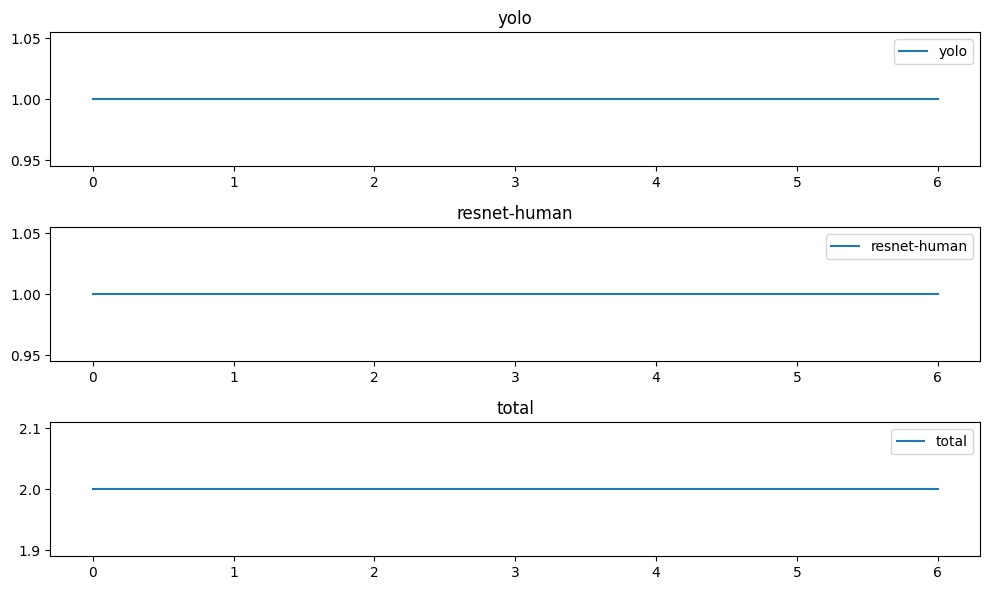

In [19]:
core_changes = {}
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [sum(x) for x in zip(*core_changes[series].values())]
    draw_dicts(core_changes[series])

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

-------------------------------------------------- 63 --------------------------------------------------


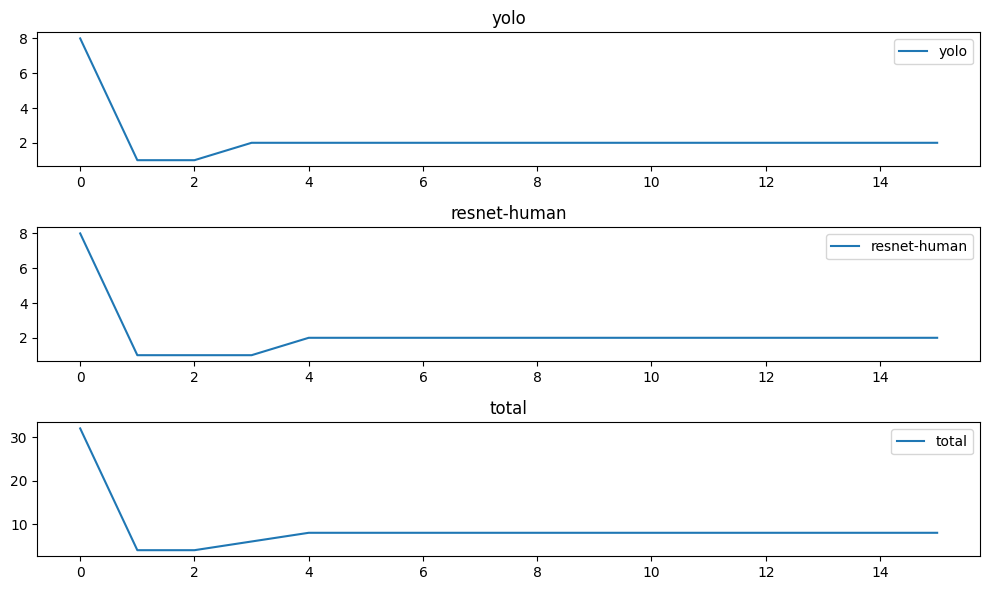

-------------------------------------------------- 64 --------------------------------------------------


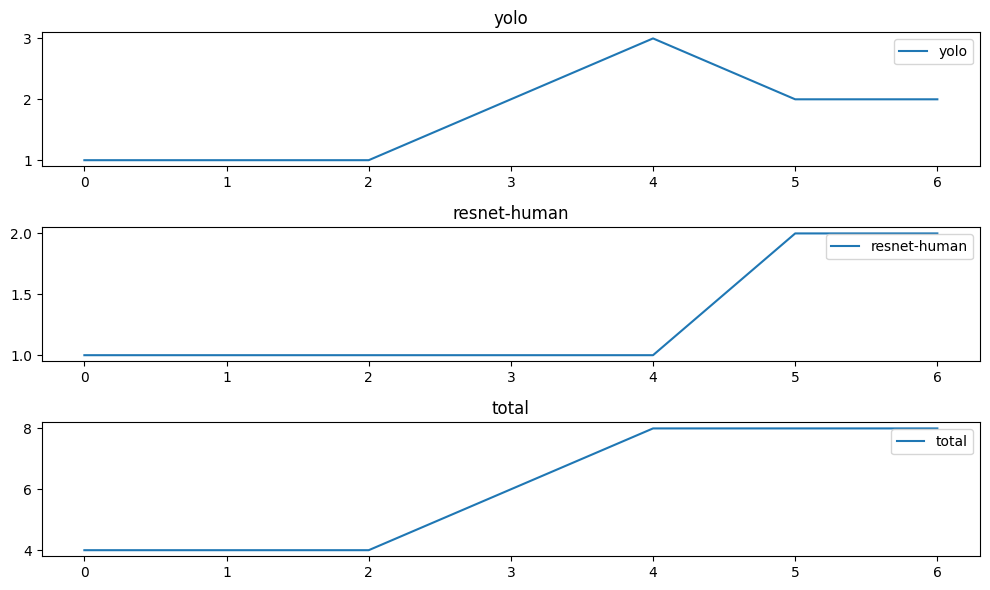

In [20]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes = {}
    for key in replica_changes[series].keys():
        total_core_changes[key] = [
            x * y for x, y in zip(replica_changes[series][key], core_changes[series][key])
        ]
    draw_dicts(total_core_changes)

## Accuracy Changes

-------------------------------------------------- 63 --------------------------------------------------


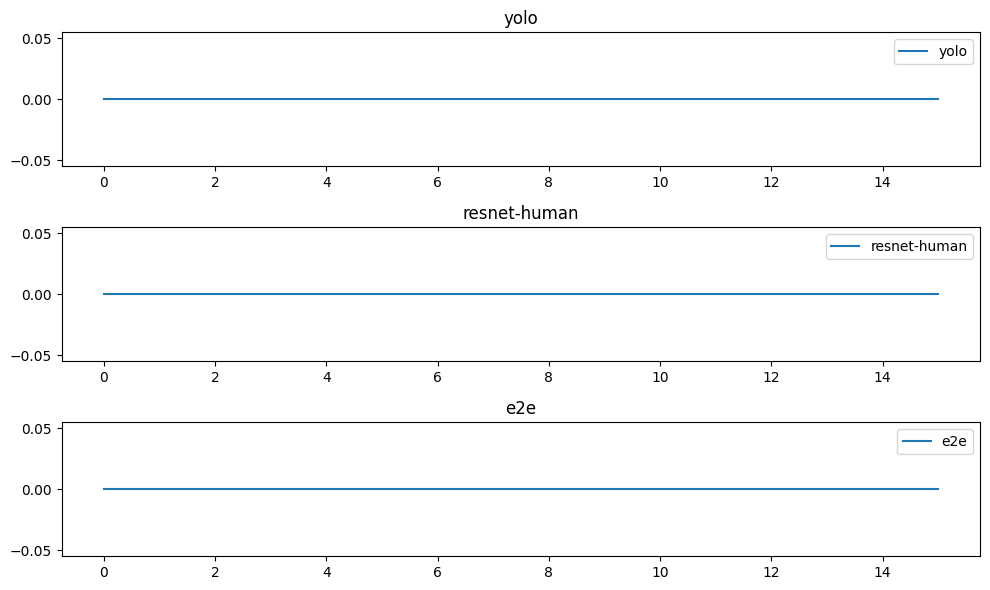

-------------------------------------------------- 64 --------------------------------------------------


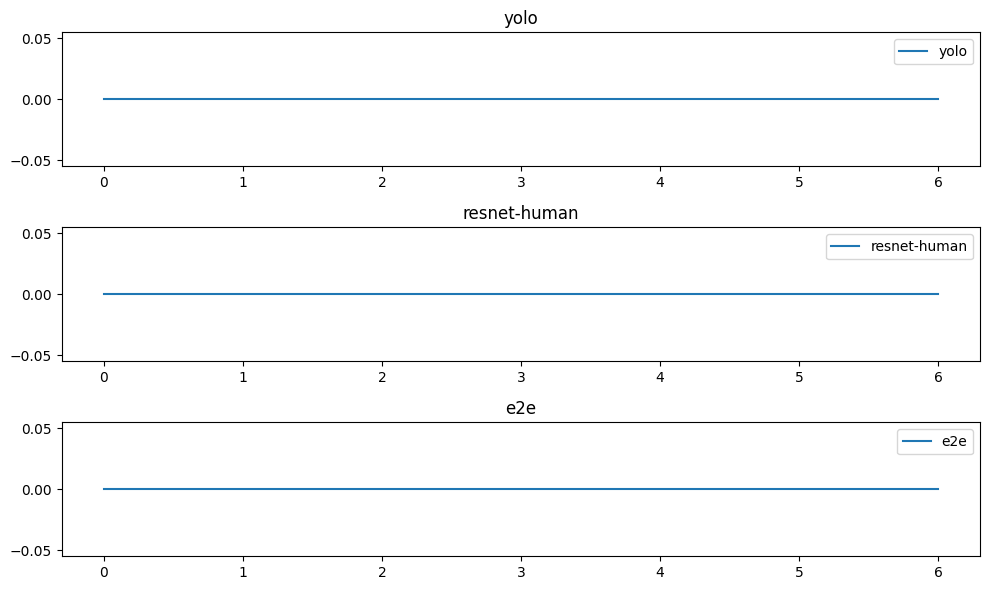

In [27]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [sum(x) for x in zip(*accuracy_changes[series].values())]
    draw_dicts(accuracy_changes[series])

## Batching Changes

-------------------------------------------------- 63 --------------------------------------------------


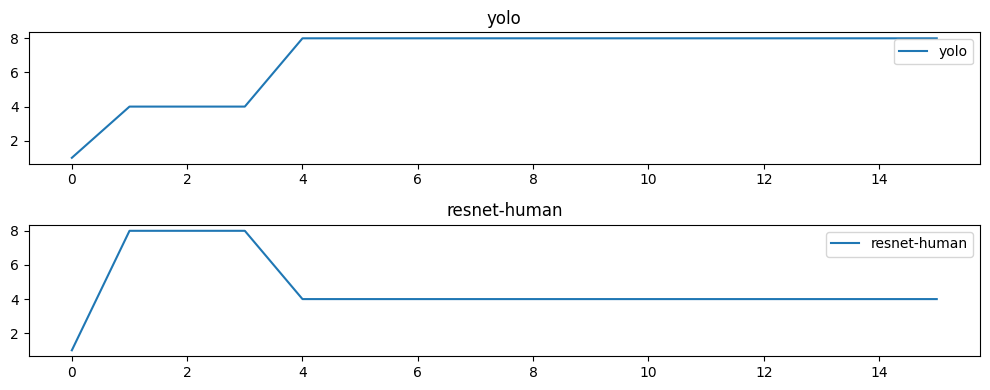

-------------------------------------------------- 64 --------------------------------------------------


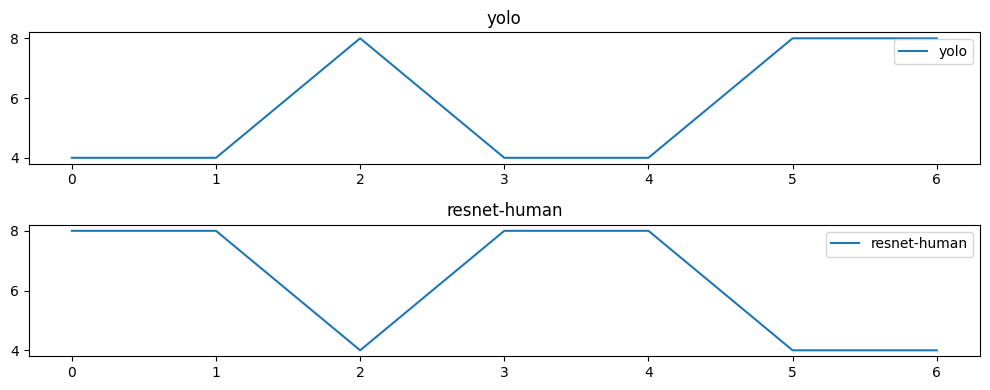

In [31]:
batching_changes = {}
for series in serieses:
    batching_changes[series] = {}
    print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        batching_changes[series][node_name] = metrics["batch"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    # batching_changes['total'] = [sum(x) for x in zip(*batching_changes.values())]
    draw_dicts(batching_changes[series])

# Expected Throughput

-------------------------------------------------- 63 --------------------------------------------------


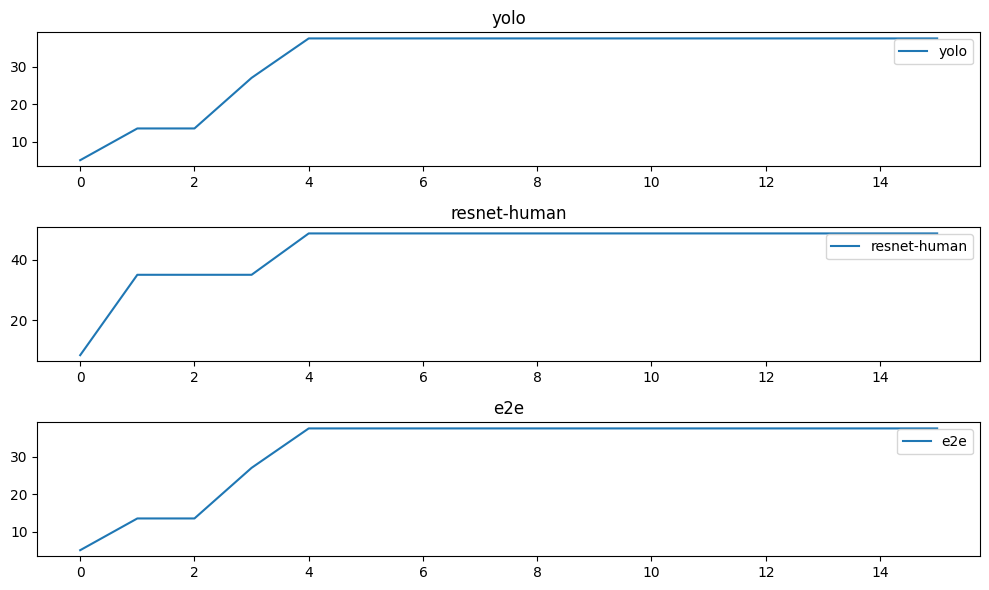

-------------------------------------------------- 64 --------------------------------------------------


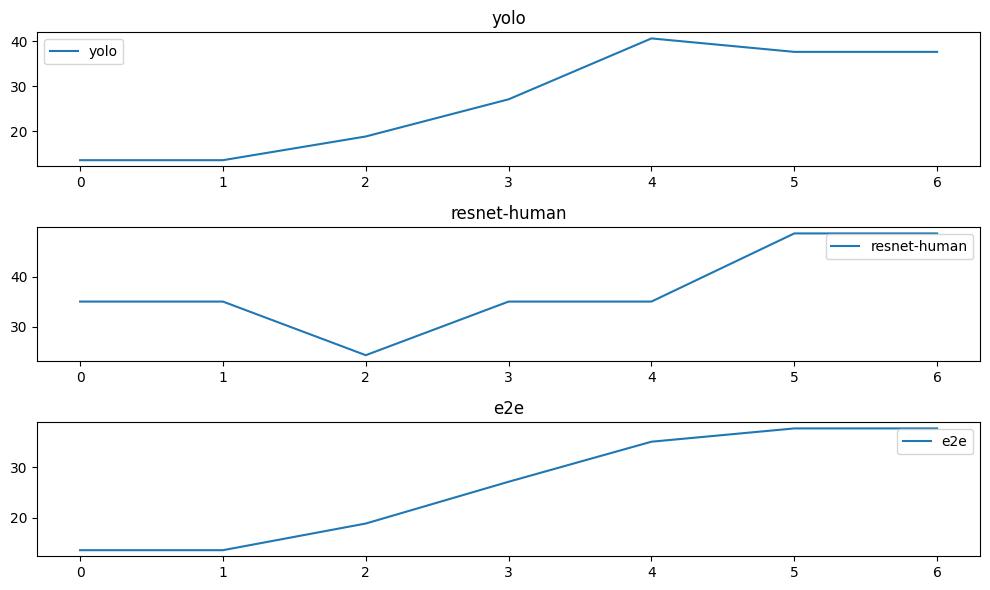

In [35]:
throughput_changes = {}
for series in serieses:
    throughput_changes[series] = {}
    print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        throughput_changes[series][node_name] = metrics["throughput"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    throughput_changes[series]["e2e"] = [min(x) for x in zip(*throughput_changes[series].values())]
    draw_dicts(throughput_changes[series])

## Expected Latency

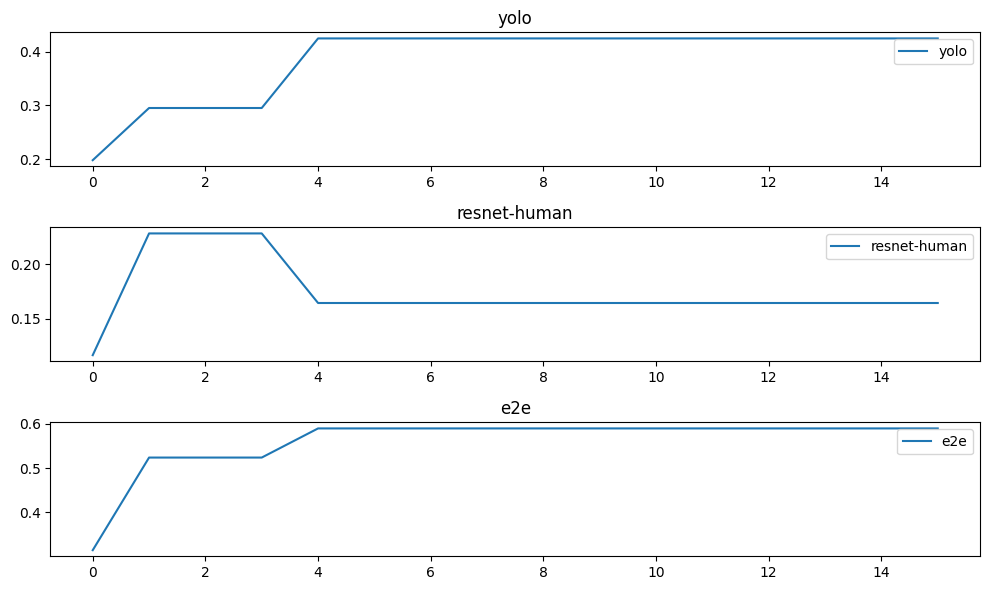

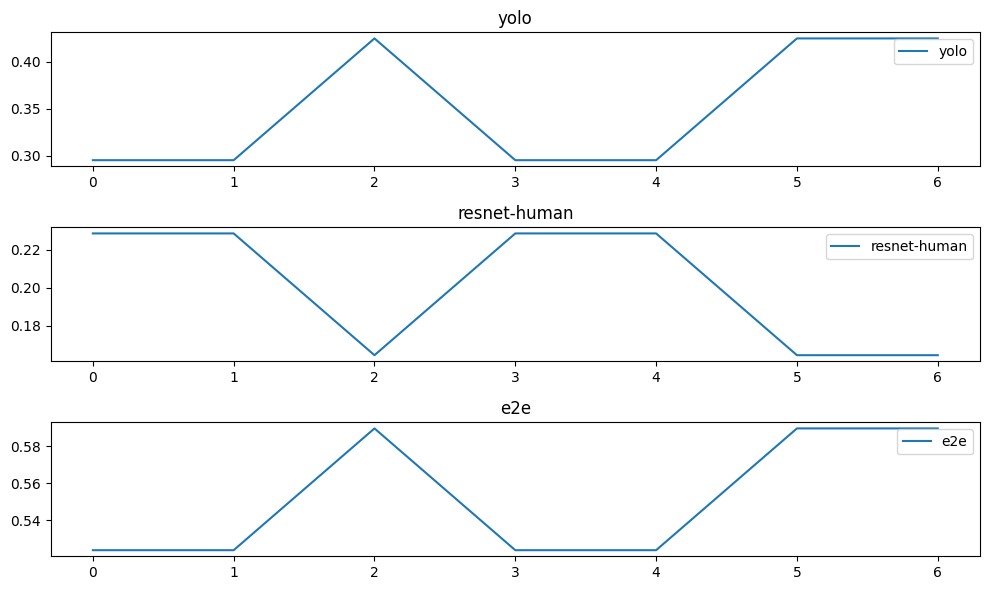

In [36]:
latency_changes = {}
for series in serieses:
    latency_changes[series] = {}
    print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        latency_changes[series][node_name] = metrics["latency"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    latency_changes[series]["e2e"] = [sum(x) for x in zip(*latency_changes[series].values())]
    draw_dicts(latency_changes[series])

# Real Latencies

## Maeseured p99 Latency


In [40]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[series].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

-------------------------------------------------- 63 --------------------------------------------------


/tmp/ipykernel_3564793/2095883171.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p99_all["p99_e2e"] = p99_all.sum(axis=1).to_list()


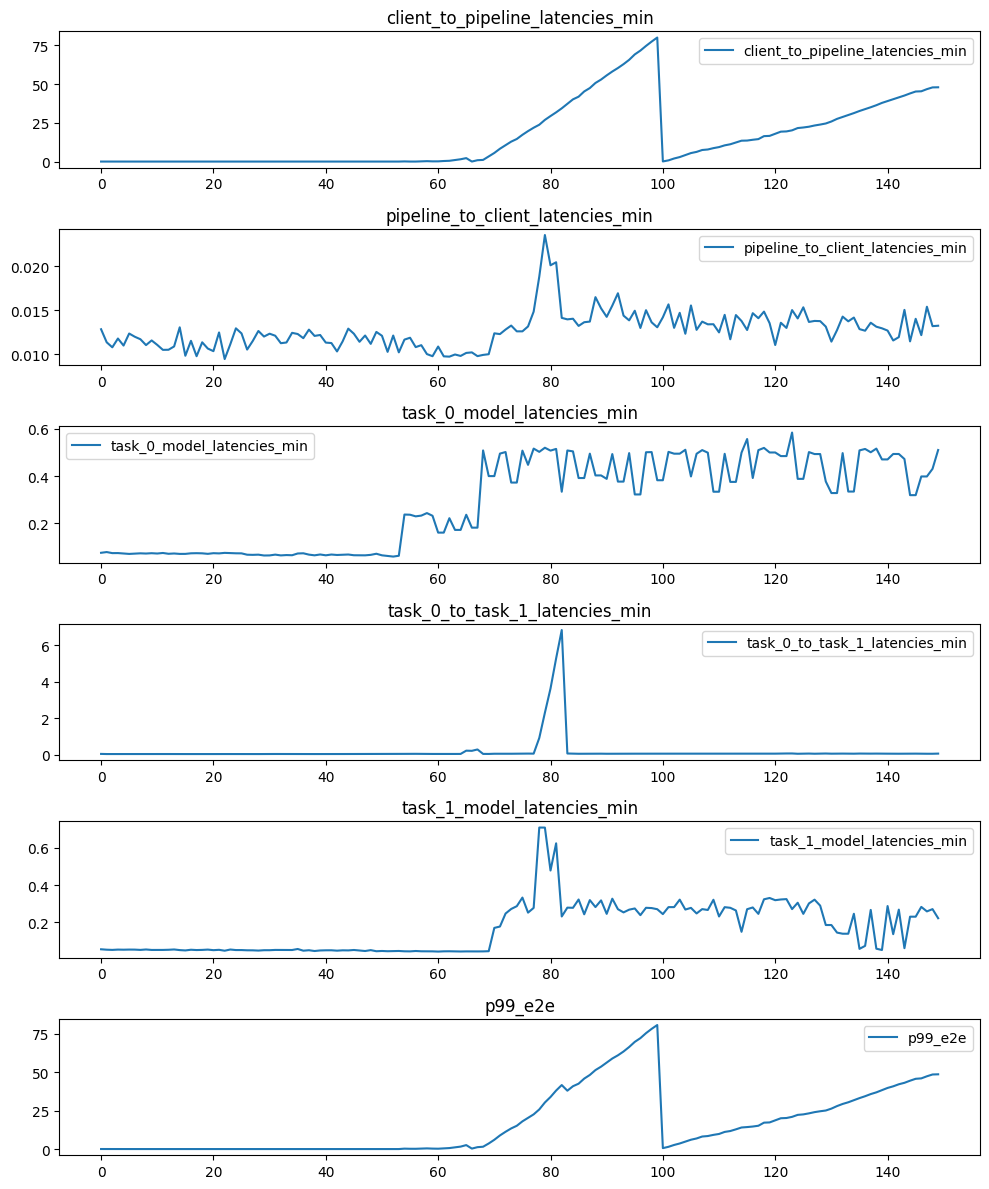

-------------------------------------------------- 64 --------------------------------------------------


In [42]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    if not simulation_modes[series]:
        p99_cols = list(filter(lambda col: "min" in col, per_second_results[series].columns))
        p99_all = per_second_results[series][p99_cols]  # [1400:]
        p99_all["p99_e2e"] = p99_all.sum(axis=1).to_list()
        draw_dicts(p99_all.to_dict(orient="list"))

# Every point a change was triggered

-------------------------------------------------- 63 --------------------------------------------------


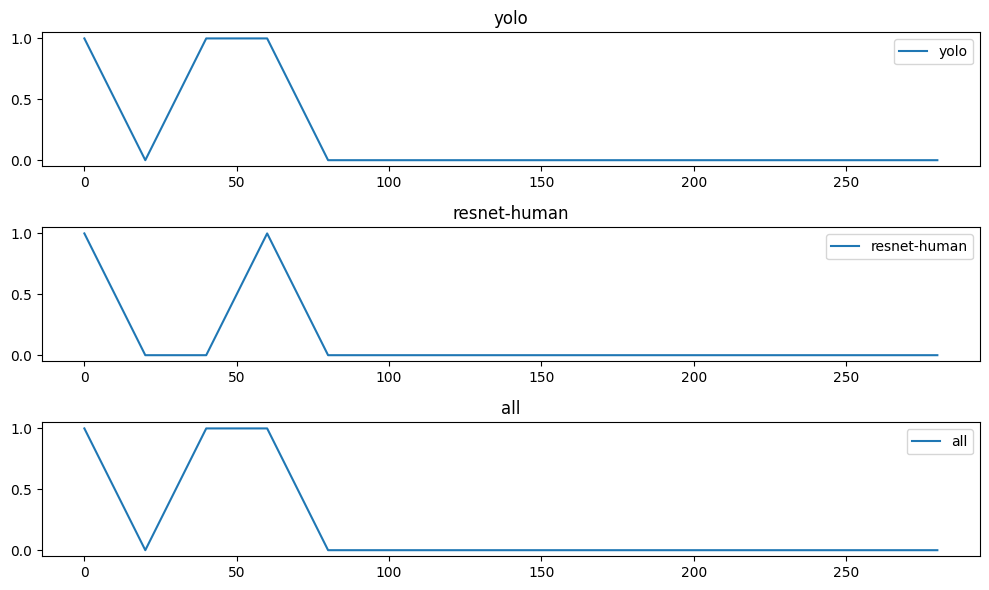

-------------------------------------------------- 64 --------------------------------------------------


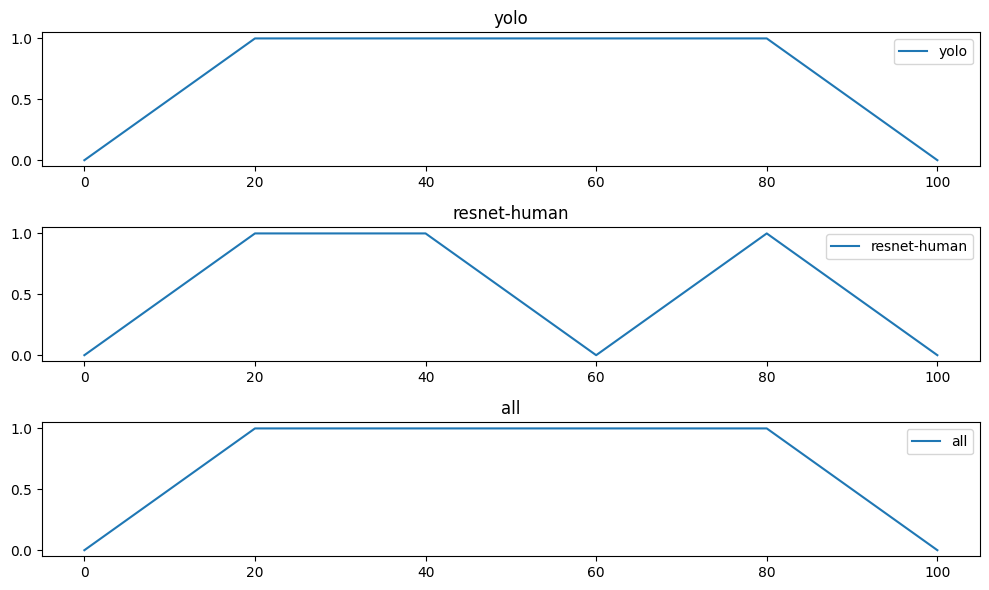

In [45]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    change_trigger = loader.points_with_change(adaptation_log=adaptation_logs[series])
    change_trigger["all"] = [any(x) for x in zip(*change_trigger.values())]
    draw_dicts(change_trigger, adaptation_interval=adaptation_intervals[series])

# Changes in the objective

-------------------------------------------------- 63 --------------------------------------------------


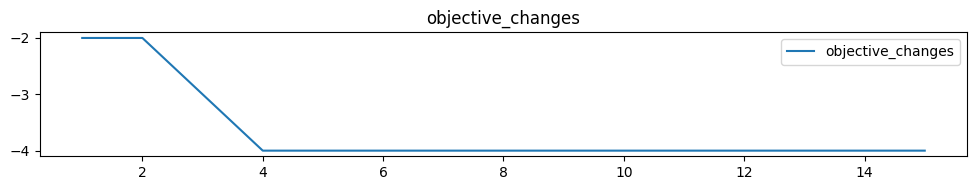

-------------------------------------------------- 64 --------------------------------------------------


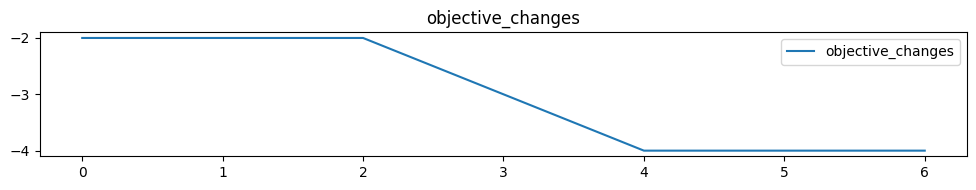

In [48]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    objective_changes = series_changes[series]["objective"]
    objective_changes = {"objective_changes": objective_changes}
    draw_dicts(objective_changes)

## Config Change

-------------------------------------------------- 63 --------------------------------------------------


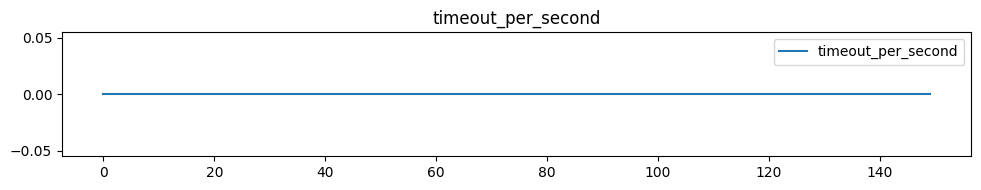

127 out of 2730
-------------------------------------------------- 64 --------------------------------------------------


In [52]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    if not simulation_modes[series]:
        timeout_dics = {"timeout_per_second": timeout_per_second[series]}
        draw_dicts(timeout_dics)
        print(f"{sum(timeout_per_second)} out of {sum(sent_loads[series])}")

In [53]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    for key, value in series_changes[series].items():
        if key == "nodes":
            for node_name, all_configs in value.items():
                print(f"node: {node_name}\n")
                for config_name, config_values in all_configs.items():
                    print(f"{config_name}: {config_values}")

-------------------------------------------------- 63 --------------------------------------------------
node: yolo

cpu: [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
replicas: [4, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
batch: [1, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
variant: ['yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n']
latency: [0.19799016909011802, 0.2952772217317099, 0.2952772217317099, 0.2952772217317099, 0.4249932919204991, 0.4249932919204991, 0.4249932919204991, 0.4249932919204991, 0.4249932919204991, 0.4249932919204991, 0.4249932919204991, 0.4249932919204991, 0.4249932919204991, 0.4249932919204991, 0.4249932919204991, 0.4249932919204991]
accuracy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
throughput: [5.050755825885657, 13.546591831707278, 13.546591831707278, 27.093183663414557, 37.64765304341